In [97]:
import epispot as epi

In [98]:
def place(t): return 0.25
def N(t): return 1e6
def R_0(t): return 2.5
def inf_to_hos(t): return 0.5
def inf_to_rec(t): return 0.5
def hos_to_dead(t): return 0.5
def hos_to_rec(t): return 0.5
def inf_to_quar(t): return 0.5

def p_quarantine(t): return 0.2
def quarantine_rate(t): return 0.3

def q_to_hos(t): return 0.4
def q_to_rec(t): return 0.6


In [99]:
class Quarantined(epi.comps.Idiom):
    def __init__(self, layer_index, p_to_hos, p_to_rec, rate_to_hos, rate_to_rec):
        super().__init__(layer_index=layer_index)
        self.p_to_hos = p_to_hos
        self.p_to_rec = p_to_rec
        self.rate_to_hos = rate_to_hos
        self.rate_to_rec = rate_to_rec

    def get_deriv(self, t, state):  # ✅ NOW it's a method
        q = state[self.layer_index]
        q_to_h = self.p_to_hos(t) * self.rate_to_hos(t) * q
        q_to_r = self.p_to_rec(t) * self.rate_to_rec(t) * q
        return {
            self.layer_index: -q_to_h - q_to_r,
            2: q_to_h,   # Hospitalized
            3: q_to_r    # Recovered
        }


In [100]:
class InfectedWithQuarantine(epi.comps.Infected):
    def __init__(self, *args, p_quarantine, quarantine_rate, quarantine_index, **kwargs):
        super().__init__(*args, **kwargs)
        self.p_quarantine = p_quarantine
        self.quarantine_rate = quarantine_rate
        self.quarantine_index = quarantine_index

    def get_deriv(self, t, state):
        # Amount of people currently infected
        i = state[self.layer_index]

        # Total rate of change from base Infected class (float)
        dI = super().get_deriv(t, state)

        # Calculate quarantine transition
        to_q = self.p_quarantine(t) * self.quarantine_rate(t) * i

        # Return a dictionary with updated values
        return {
            self.layer_index: dI - to_q,  # remove quarantined from I
            self.quarantine_index: to_q  # add to quarantine
        }


In [101]:
class MySusceptible(epi.comps.Susceptible):
    def get_deriv(self, t, state):
        dS = super().get_deriv(t, state)
        return {self.layer_index: dS}

class MyHospitalized(epi.comps.Hospitalized):
    def get_deriv(self, t, state):
        dH = super().get_deriv(t, state)
        return {self.layer_index: dH}

class MyRecovered(epi.comps.Recovered):
    def get_deriv(self, t, state):
        dR = super().get_deriv(t, state)
        return {self.layer_index: dR}

class MyDead(epi.comps.Dead):
    def get_deriv(self, t, state):
        dD = super().get_deriv(t, state)
        return {self.layer_index: dD}

In [102]:
Susceptible = MySusceptible(layer_index=0,
                                    R_0=R_0,
                                    gamma=place,
                                    N=N)

InfectedQ = InfectedWithQuarantine(layer_index=1,
                                   N=N,
                                   R_0=R_0,
                                   gamma=place,
                                   recovery_rate=place,
                                   p_recovery=inf_to_rec,
                                   p_hospitalized=inf_to_hos,
                                   hospital_rate=place,
                                   p_quarantine=p_quarantine,
                                   quarantine_rate=quarantine_rate,
                                   quarantine_index=5)

Hospitalized = MyHospitalized(layer_index=2,
                                      p_hos=inf_to_hos,
                                      hos_rate=place,
                                      alpha=hos_to_dead,
                                      rho=place,
                                      p_recovery=hos_to_rec,
                                      recovery_rate=place)

Recovered = MyRecovered(layer_index=3,
                                p_from_inf=inf_to_rec,
                                from_inf_rate=place,
                                p_from_hos=hos_to_rec,
                                from_hos_rate=place)

Dead = MyDead(layer_index=4,
                      alpha_hos=hos_to_dead,
                      rho_hos=place)

Quarantine = Quarantined(layer_index=5,
                         p_to_hos=q_to_hos,
                         p_to_rec=q_to_rec,
                         rate_to_hos=place,
                         rate_to_rec=place)

In [103]:
SIHRDQ_Model = epi.models.Model(init_pop=N(0))
SIHRDQ_Model.add_layer(layer=Susceptible, layer_name='Susceptible', layer_map=[InfectedQ])
SIHRDQ_Model.add_layer(layer=InfectedQ, layer_name='Infected', layer_map=[Hospitalized, Recovered, Quarantine])
SIHRDQ_Model.add_layer(layer=Hospitalized, layer_name='Hospitalized', layer_map=[Dead, Recovered])
SIHRDQ_Model.add_layer(layer=Quarantine, layer_name='Quarantine', layer_map=[Hospitalized, Recovered])
SIHRDQ_Model.add_layer(layer=Recovered, layer_name='Recovered', layer_map=[])
SIHRDQ_Model.add_layer(layer=Dead, layer_name='Dead', layer_map=[])

In [104]:
def flatten_derivatives(deriv_list, num_layers):
    # Create a flat derivative list with one float per compartment index
    flat = [0.0 for _ in range(num_layers)]
    for d in deriv_list:
        if isinstance(d, dict):
            for k, v in d.items():
                flat[k] += v
        else:
            # fallback if a float was returned
            flat[deriv_list.index(d)] += d
    return flat

# Monkey-patch the model's get_deriv method
def patched_get_deriv(self, time, system):
    derivs = []
    for layer in self.layers:
        derivs.append(layer.get_deriv(time, system))
    return flatten_derivatives(derivs, len(self.layers))

import types
SIHRDQ_Model.get_deriv = types.MethodType(patched_get_deriv, SIHRDQ_Model)

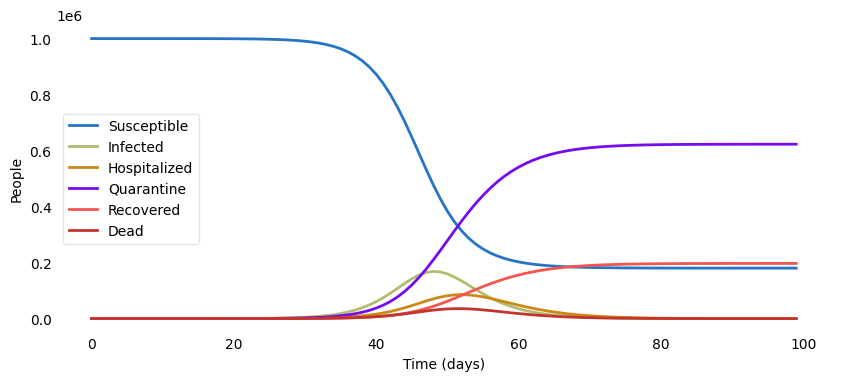

In [105]:
Plot = epi.plots.plot_comp_nums(SIHRDQ_Model, range(100))
#Plot.show()  # uncomment for newer versions of epispot (>2.1.1)